In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns

from ucimlrepo import fetch_ucirepo
air_quality = fetch_ucirepo(id=360) 

# X = air_quality.data.features

vars_df = pd.DataFrame(air_quality.variables)
pd.set_option('display.max_colwidth', 200)

#drop useless columns
vars_df = vars_df.drop(columns=['demographic', 'missing_values'], errors='ignore')

display(vars_df.style.set_properties(subset=['description'], **{'text-align': 'left'}))

df = pd.DataFrame(air_quality.data.features)
df.head()

,name,role,type,description,units
0,Date,Feature,Date,None,None
1,Time,Feature,Categorical,None,None
2,CO(GT),Feature,Integer,True hourly averaged concentration CO in mg/m^3 (reference analyzer),mg/m^3
3,PT08.S1(CO),Feature,Categorical,hourly averaged sensor response (nominally CO targeted),None
4,NMHC(GT),Feature,Integer,True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer),microg/m^3
5,C6H6(GT),Feature,Continuous,True hourly averaged Benzene concentration in microg/m^3 (reference analyzer),microg/m^3
6,PT08.S2(NMHC),Feature,Categorical,hourly averaged sensor response (nominally NMHC targeted),None
7,NOx(GT),Feature,Integer,True hourly averaged NOx concentration in ppb (reference analyzer),ppb
8,PT08.S3(NOx),Feature,Categorical,hourly averaged sensor response (nominally NOx targeted),None
9,NO2(GT),Feature,Integer,True hourly averaged NO2 concentration in microg/m^3 (reference analyzer),microg/m^3


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


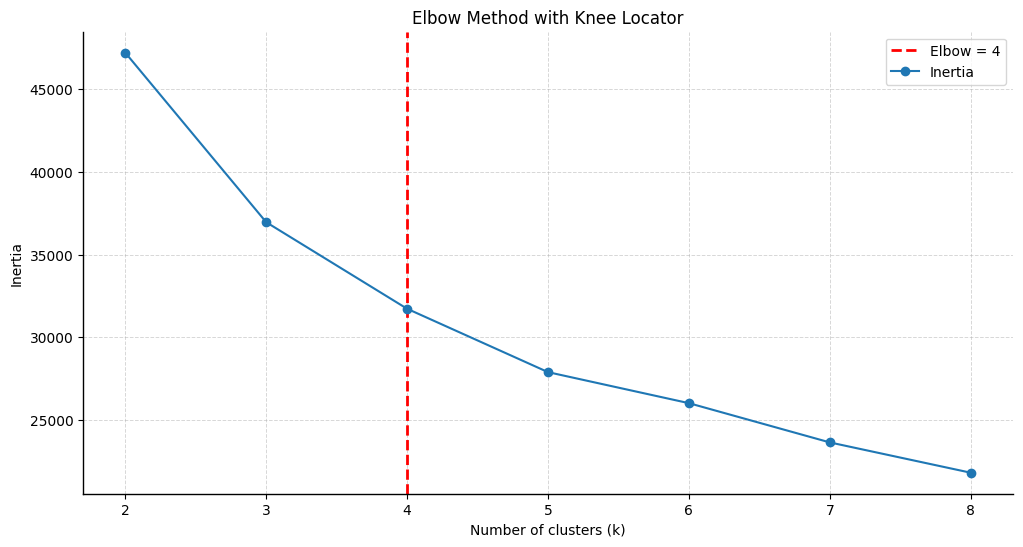

In [2]:
# Select relevant features and clean data
features = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 
            'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
X = df[features]
X = X.replace(-200, np.nan).dropna()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute inertia for k values from 2 to 8
K_values = range(2, 9)
inertias = []
for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Identify and plot the elbow point
kneedle = KneeLocator(K_values, inertias, curve='convex', direction='decreasing')
knee_point = kneedle.elbow
plt.figure(figsize=(12, 6))
plt.axvline(x=knee_point, color='red', linestyle='--', linewidth=2, label=f'Elbow = {knee_point}')
plt.plot(K_values, inertias, marker='o', linestyle='-', label='Inertia')

# Customize plot appearance
plt.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Add labels and title
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method with Knee Locator')
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.show()

In [3]:
from sklearn.metrics import silhouette_score

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}, silhouette={score:.3f}")

k=2, silhouette=0.292
k=3, silhouette=0.263
k=3, silhouette=0.263
k=4, silhouette=0.243
k=4, silhouette=0.243
k=5, silhouette=0.235
k=5, silhouette=0.235
k=6, silhouette=0.211
k=6, silhouette=0.211
k=7, silhouette=0.220
k=7, silhouette=0.220
k=8, silhouette=0.215
k=8, silhouette=0.215
k=9, silhouette=0.216
k=9, silhouette=0.216


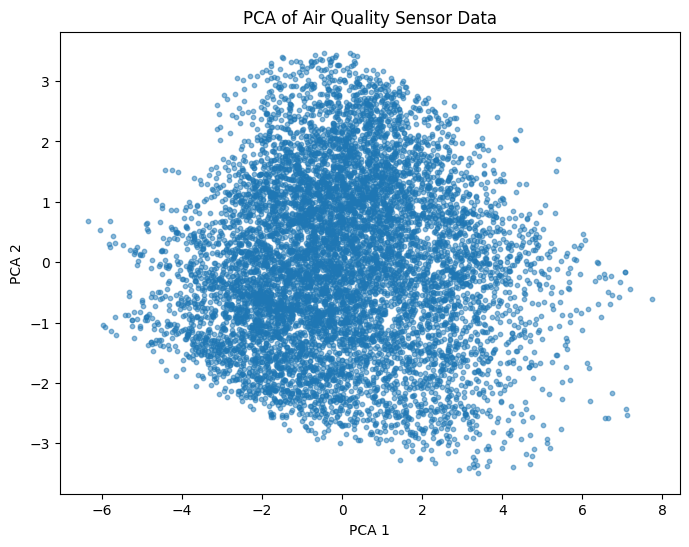

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.5)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of Air Quality Sensor Data')
plt.show()



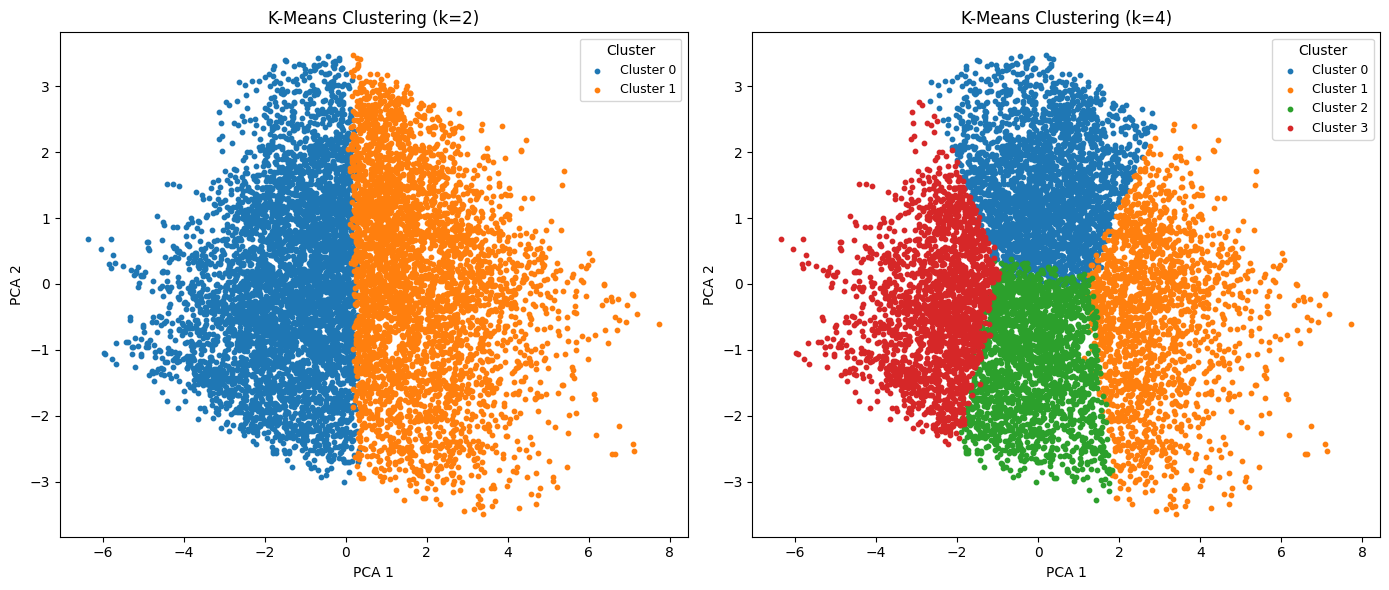

In [5]:
kmeans2 = KMeans(n_clusters=2, random_state=42)
labels2 = kmeans2.fit_predict(X_scaled)

kmeans4 = KMeans(n_clusters=4, random_state=42)
labels4 = kmeans4.fit_predict(X_scaled)

# --- Color palettes ---
colors2 = plt.cm.tab10(np.arange(2))
colors4 = plt.cm.tab10(np.arange(4))

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ===== Left: k=2 =====
for i, color in zip(range(2), colors2):
    axes[0].scatter(
    X_pca[labels2 == i, 0],
    X_pca[labels2 == i, 1],
    s=10, color=color, label=f'Cluster {i}'
    )
axes[0].set_title('K-Means Clustering (k=2)')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].legend(title='Cluster', loc='best', fontsize=9)

# ===== Right: k=4 =====
for i, color in zip(range(4), colors4):
    axes[1].scatter(
        X_pca[labels4 == i, 0],
        X_pca[labels4 == i, 1],
        s=10, color=color, label=f'Cluster {i}'
    )
axes[1].set_title('K-Means Clustering (k=4)')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].legend(title='Cluster', loc='best', fontsize=9)

plt.tight_layout()
plt.show()

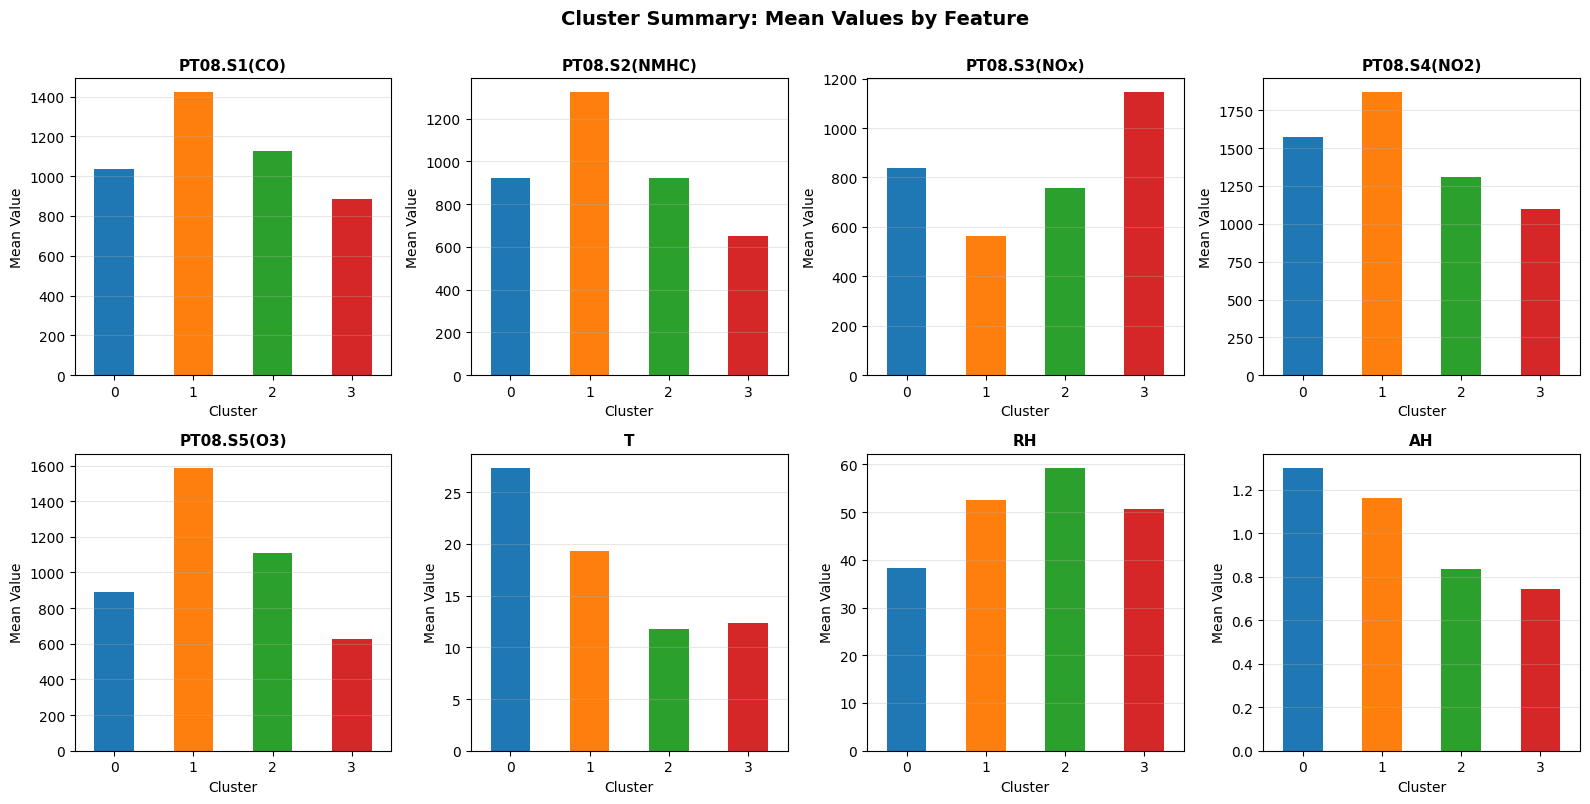

,PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
cluster,,,,,,,,
0,1035.398790,922.311989,838.300605,1576.248310,889.317681,27.353184,38.249235,1.300006
1,1420.630553,1322.315818,564.237811,1867.505417,1586.476706,19.300325,52.598104,1.160326
2,1124.365349,923.358915,756.231618,1308.049173,1109.255515,11.754779,59.238419,0.835659
3,884.611214,649.251622,1143.798424,1097.641798,627.757646,12.325765,50.577943,0.744147


In [6]:
df_clean = X.copy()
df_clean['cluster'] = labels4
cluster_summary = df_clean.groupby('cluster').mean()

# Visualize cluster summary with grouped bar chart
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(cluster_summary.columns):
    ax = axes[idx]
    cluster_summary[feature].plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_title(feature, fontweight='bold', fontsize=11)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Mean Value')
    ax.grid(axis='y', alpha=0.3)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.suptitle('Cluster Summary: Mean Values by Feature', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Also display the table for reference
cluster_summary

## Cluster Interpretation

To explain the clusters, we'll:
1. **Examine cluster centroids** - mean values for each feature
2. **Visualize radar/parallel plots** - show cluster profiles
3. **Identify dominant characteristics** - what makes each cluster unique
4. **Contextualize findings** - relate to air quality conditions

In [7]:
# Create a detailed cluster explanation
cluster_names = {}
cluster_descriptions = {}

# Analyze each cluster
for cluster_id in sorted(cluster_summary.index):
    cluster_data = cluster_summary.loc[cluster_id]
    
    # Identify key characteristics
    characteristics = []
    
    # Check pollutant levels
    if cluster_data['PT08.S1(CO)'] > cluster_summary['PT08.S1(CO)'].median():
        characteristics.append("High CO")
    if cluster_data['PT08.S3(NOx)'] > cluster_summary['PT08.S3(NOx)'].median():
        characteristics.append("High NOx")
    if cluster_data['PT08.S5(O3)'] > cluster_summary['PT08.S5(O3)'].median():
        characteristics.append("High O3")
    
    # Check weather
    if cluster_data['T'] > cluster_summary['T'].median():
        characteristics.append("Warm")
    else:
        characteristics.append("Cool")
    
    if cluster_data['RH'] > cluster_summary['RH'].median():
        characteristics.append("Humid")
    else:
        characteristics.append("Dry")
    
    # Store characteristics
    cluster_descriptions[cluster_id] = ", ".join(characteristics)
    print(f"Cluster {cluster_id}: {cluster_descriptions[cluster_id]}")
    print(f"  Sample size: {(labels4 == cluster_id).sum()} observations")
    print()

Cluster 0: High NOx, Warm, Dry
  Sample size: 2811 observations

Cluster 1: High CO, High O3, Warm, Humid
  Sample size: 1846 observations

Cluster 2: High CO, High O3, Cool, Humid
  Sample size: 2176 observations

Cluster 3: High NOx, Cool, Dry
  Sample size: 2158 observations



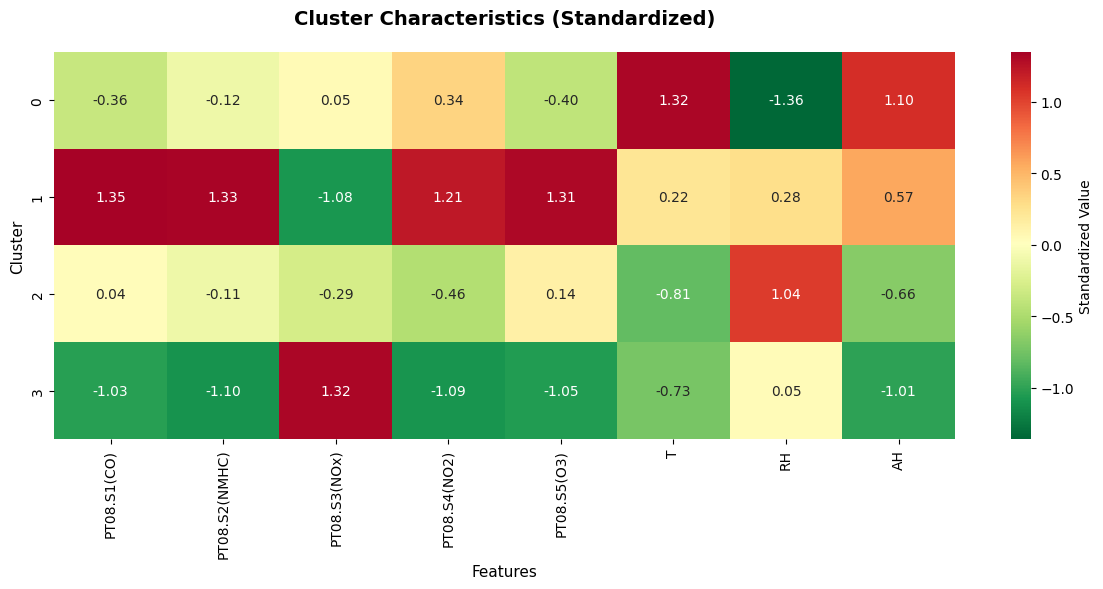

In [8]:
# Create a heatmap comparing clusters
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize for better color contrast
cluster_summary_scaled = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

sns.heatmap(cluster_summary_scaled, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=0, cbar_kws={'label': 'Standardized Value'}, ax=ax)
ax.set_title('Cluster Characteristics (Standardized)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Features', fontsize=11)
ax.set_ylabel('Cluster', fontsize=11)

plt.tight_layout()
plt.show()

## Multivariate Check: Predicting Cluster Labels with Random Forest

We’ll train a supervised model to predict the unsupervised cluster labels. High performance suggests clusters are separable in the feature space.

What we’ll do:
- Prepare features (`X`) and labels (`y = cluster`)
- Stratified train/validation split
- Train `RandomForestClassifier`
- Evaluate accuracy, macro-F1, confusion matrix
- Inspect feature importance: impurity-based and permutation
- Optional: SHAP summary if available

In [9]:
# Prepare data for supervised prediction of cluster labels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Use the same features used for clustering
X_rf = df_clean[features].copy()
y_rf = df_clean['cluster'].astype(int).copy()

# Train/validation split with stratification to preserve cluster proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

# Fit Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("Model trained: RandomForestClassifier")

Model trained: RandomForestClassifier


Accuracy: 0.967
Macro F1: 0.966

Classification Report:

              precision    recall  f1-score   support

           0      0.962     0.977     0.969       563
           1      0.957     0.965     0.961       369
           2      0.970     0.954     0.962       435
           3      0.979     0.968     0.973       432

    accuracy                          0.967      1799
   macro avg      0.967     0.966     0.966      1799
weighted avg      0.967     0.967     0.967      1799



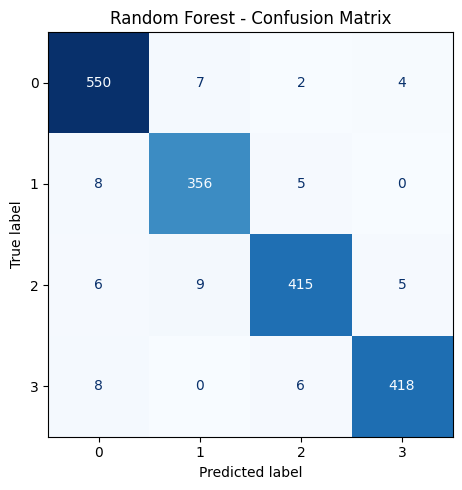

In [10]:
# Evaluate performance
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.3f}")
print(f"Macro F1: {macro_f1:.3f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Random Forest - Confusion Matrix')
plt.tight_layout()
plt.show()

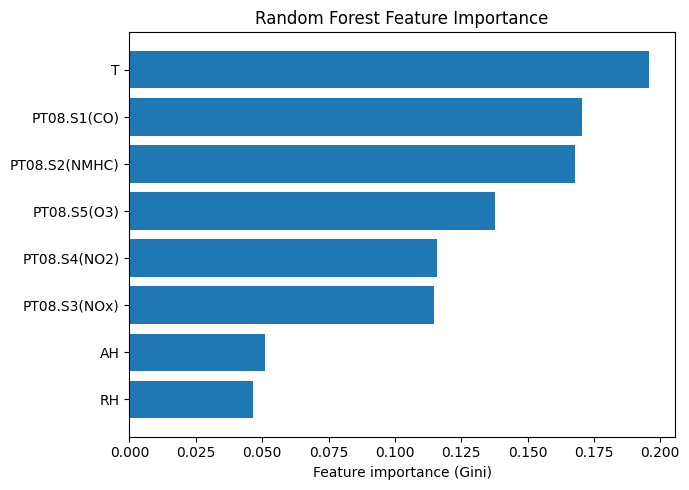

In [11]:
# Feature importance (impurity-based)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(7, 5))
plt.barh(importances.index, importances.values, color='#1f77b4')
plt.xlabel('Feature importance (Gini)')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

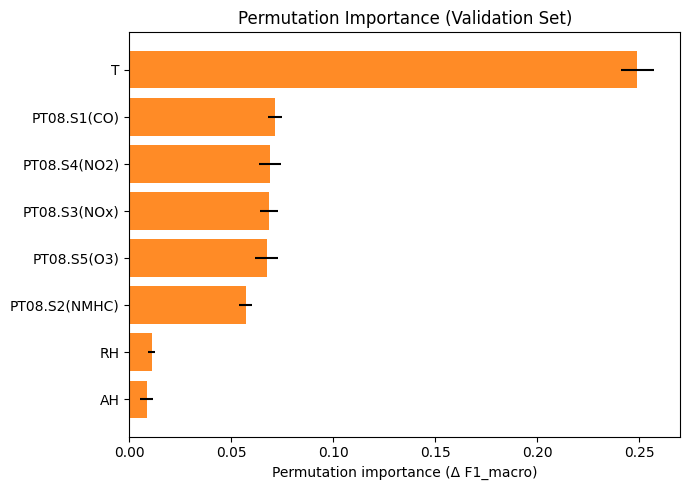

In [12]:
# Permutation importance (model-agnostic)
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='f1_macro'
)

perm_importances = pd.Series(perm.importances_mean, index=features).sort_values(ascending=True)
perm_err = pd.Series(perm.importances_std, index=features).loc[perm_importances.index]

plt.figure(figsize=(7, 5))
plt.barh(perm_importances.index, perm_importances.values, xerr=perm_err.values, color='#ff7f0e', alpha=0.9)
plt.xlabel('Permutation importance (Δ F1_macro)')
plt.title('Permutation Importance (Validation Set)')
plt.tight_layout()
plt.show()

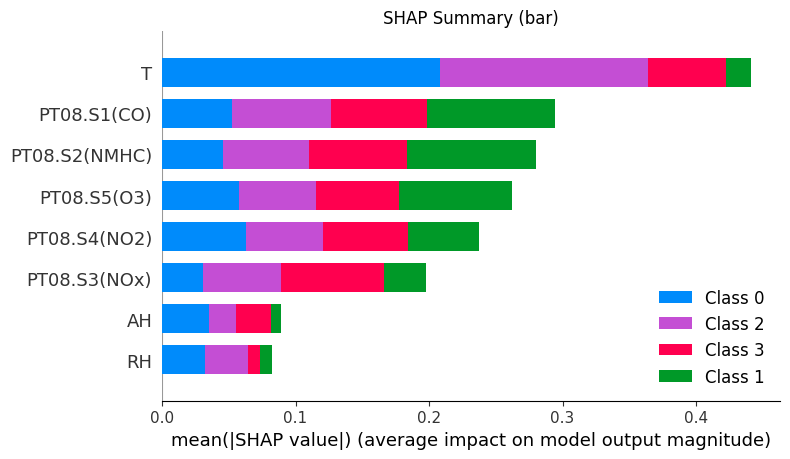

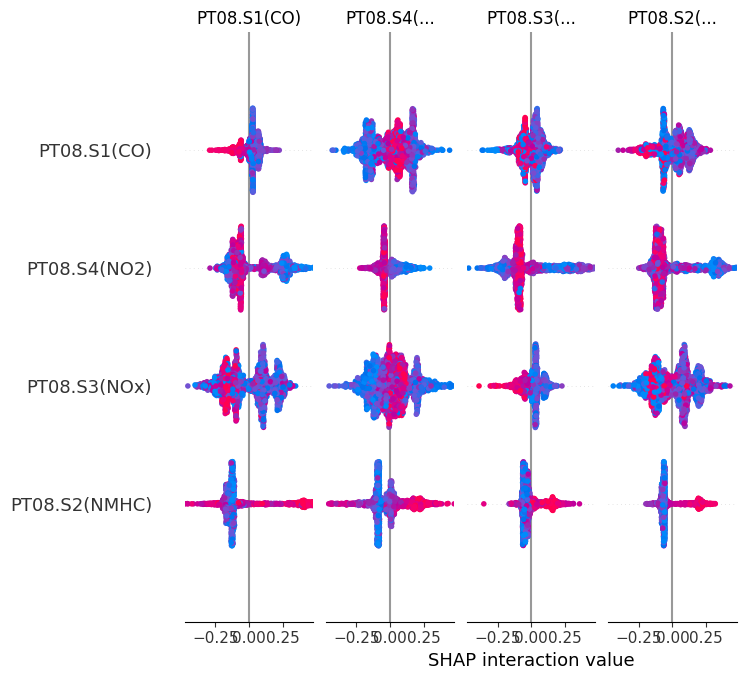

In [ ]:
# Optional: SHAP values for local and global explanations
import shap


# Use a small background set for speed
explainer = shap.TreeExplainer(rf)
# SHAP expects numpy arrays
shap_values = explainer.shap_values(X_test)
   
plt.figure(figsize=(8, 5))
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type='bar', show=False)
plt.title('SHAP Summary (bar)')
plt.tight_layout()
plt.show()
 
# Detailed summary
shap.summary_plot(shap_values, X_test, feature_names=features, show=True)

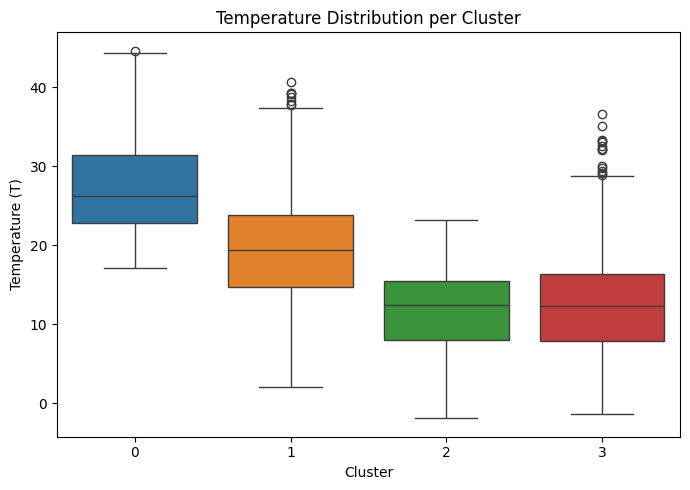

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure consistent cluster color mapping across plots
# Use string labels to match seaborn's expected palette keys
df_plot = df_clean.copy()
df_plot['cluster_str'] = df_plot['cluster'].astype(str)
clusters_str = sorted(df_plot['cluster_str'].unique(), key=lambda s: int(s))

cluster_colors = sns.color_palette('tab10', n_colors=len(clusters_str))
cluster_palette = {c: cluster_colors[i] for i, c in enumerate(clusters_str)}

plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    data=df_plot,
    x='cluster_str', y='T',
    order=clusters_str,
    hue='cluster_str',
    palette=cluster_palette,
    dodge=False  # same hue as x; avoid side-by-side duplication
)
# Remove redundant legend (since hue == x)
leg = ax.get_legend()
if leg is not None:
    leg.remove()

plt.title('Temperature Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Temperature (T)')
plt.tight_layout()
plt.show()

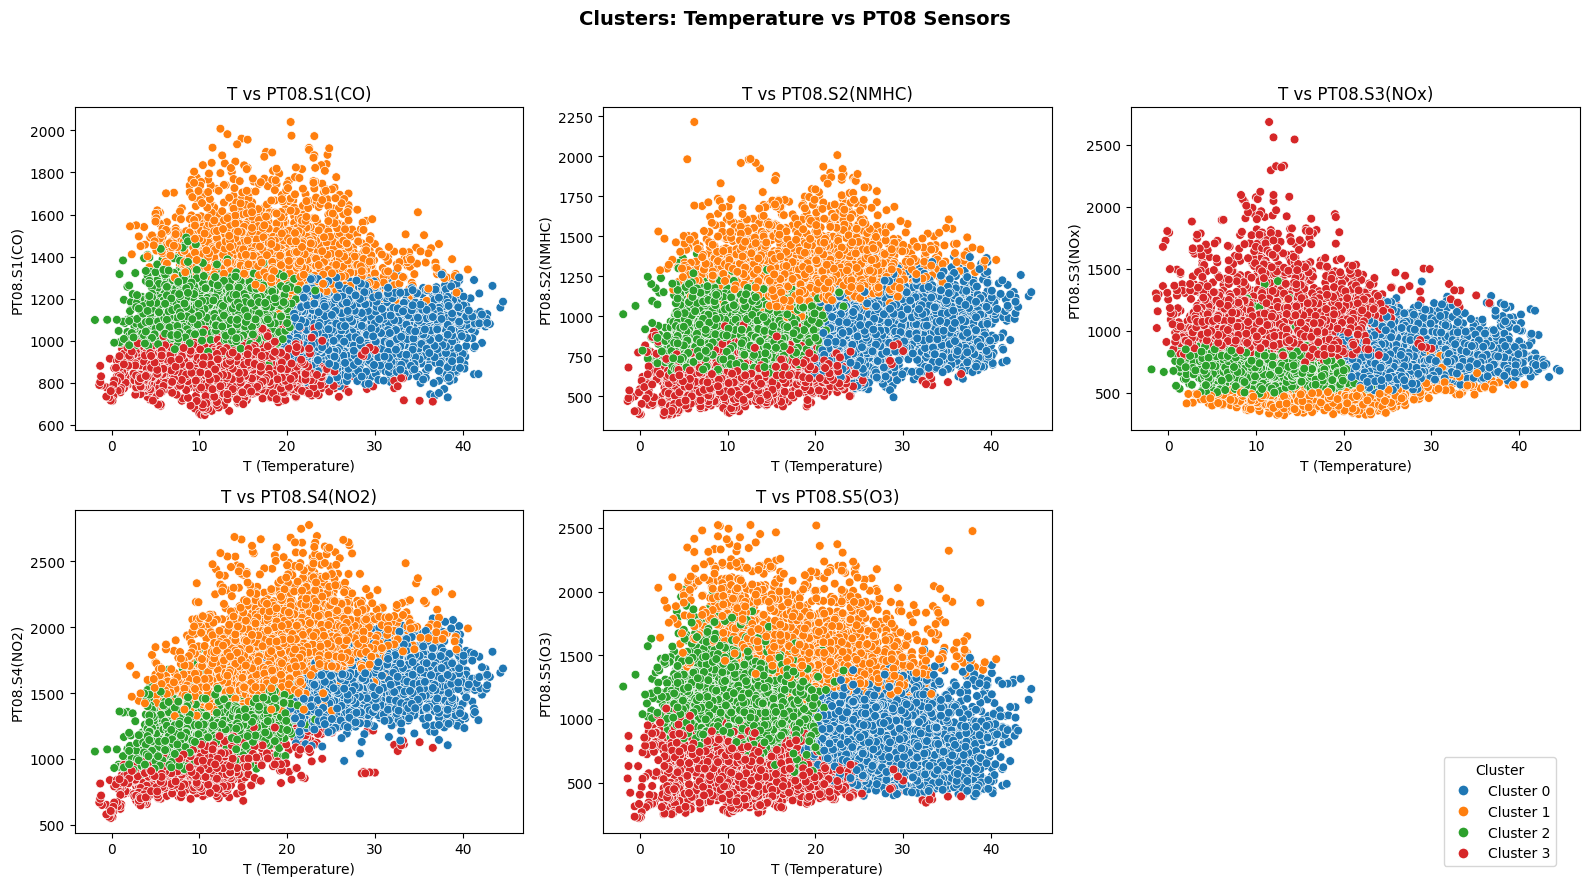

In [28]:
# Side-by-side (2 rows): Temperature vs each PT08 sensor, colored by cluster
from matplotlib.lines import Line2D

sensor_cols = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
rows, cols = 2, 3

fig, axes = plt.subplots(rows, cols, figsize=(16, 9), sharex=False, sharey=False)
axes = np.array(axes).reshape(rows, cols).flatten()

# Plot first 5 sensors across a 2x3 grid (last axis unused)
for ax, sensor in zip(axes, sensor_cols):
    sns.scatterplot(
        data=df_clean,
        x='T', y=sensor,
        hue='cluster', palette='tab10', s=40,
        ax=ax, legend=False
    )
    ax.set_title(f'T vs {sensor}')
    ax.set_xlabel('T (Temperature)')
    ax.set_ylabel(sensor)

# Hide any unused axes (the 6th one)
for ax in axes[len(sensor_cols):]:
    ax.axis('off')

# Build a shared legend (bottom-right to avoid covering the title)
clusters = sorted(df_clean['cluster'].unique())
palette = sns.color_palette('tab10', n_colors=len(clusters))
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {int(c)}',
           markerfacecolor=palette[i], markersize=8)
    for i, c in enumerate(clusters)
]

fig.legend(handles=legend_handles, loc='lower right', ncol=1, title='Cluster', bbox_to_anchor=(0.98, 0.02), frameon=True)
fig.suptitle('Clusters: Temperature vs PT08 Sensors', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [14]:
# Statistical comparison between clusters
print("="*80)
print("CLUSTER INTERPRETATION SUMMARY")
print("="*80)

for cluster_id in sorted(cluster_summary.index):
    print(f"\n{'Cluster ' + str(cluster_id):=^80}")
    print(f"Size: {(labels4 == cluster_id).sum()} observations ({(labels4 == cluster_id).sum()/len(labels4)*100:.1f}%)")
    print(f"\nKey Characteristics:")
    
    cluster_data = cluster_summary.loc[cluster_id]
    overall_mean = cluster_summary.mean()
    
    # Find distinguishing features (>20% different from overall mean)
    distinguishing = []
    for feature in cluster_summary.columns:
        diff_pct = ((cluster_data[feature] - overall_mean[feature]) / overall_mean[feature]) * 100
        if abs(diff_pct) > 20:
            direction = "higher" if diff_pct > 0 else "lower"
            distinguishing.append(f"  • {feature}: {direction} than average ({diff_pct:+.1f}%)")
    
    if distinguishing:
        print("\n".join(distinguishing))
    else:
        print("  • Near-average conditions across all features")
    
    print()

print("="*80)

CLUSTER INTERPRETATION SUMMARY

===================================Cluster 0====================================
Size: 2811 observations (31.3%)

Key Characteristics:
  • T: higher than average (+54.7%)
  • RH: lower than average (-23.8%)
  • AH: higher than average (+28.7%)


===================================Cluster 1====================================
Size: 1846 observations (20.5%)

Key Characteristics:
  • PT08.S1(CO): higher than average (+27.3%)
  • PT08.S2(NMHC): higher than average (+38.6%)
  • PT08.S3(NOx): lower than average (-31.7%)
  • PT08.S4(NO2): higher than average (+27.7%)
  • PT08.S5(O3): higher than average (+50.6%)


===================================Cluster 2====================================
Size: 2176 observations (24.2%)

Key Characteristics:
  • T: lower than average (-33.5%)


===================================Cluster 3====================================
Size: 2158 observations (24.0%)

Key Characteristics:
  • PT08.S1(CO): lower than average (-20.8%)
